### This code creates sea-ice anomalies for the years of peak and no intrusions. The final figure is assembled in inkscape and contains a time series between the sea ice and the temperature box.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34023/status,
Dashboard: /proxy/34023/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42553,Workers: 7
Dashboard: /proxy/34023/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:44473,Total threads: 4
Dashboard: /proxy/35509/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:36401,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

## SEA ICE CONCENTRATION

Here we load sea-ice monthly concentration. Note that aice_m is the monthly average of fractional ice area in each grid cell aka the concentration. To find the actual area of the ice we need to know the area of each cell. Unfortunately, CICE doesn't save this for us ... but the ocean model does. So, let's load area_t from the ocean model, and rename the coordinates in our ice variable to match the ocean model. Then we can multiply the ice concentration with the cell area to get a total ice area.

In [4]:
# cut the data BOX 1
lon_slice  = slice(-256, -245)
lat_slice  = slice(-67.5, -61)


first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

var=cc.querying.getvar(iaf_cycle3,'aice_m' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time, decode_coords = False)
area_t = cc.querying.getvar(iaf_cycle3, 'area_t',master_session,n = 1)
var.coords['ni'] = area_t['xt_ocean'].values
var.coords['nj'] = area_t['yt_ocean'].values
var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
ice_all=var.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
#ice_all=ice_all.mean(dim='time')
ice_all=ice_all.load()

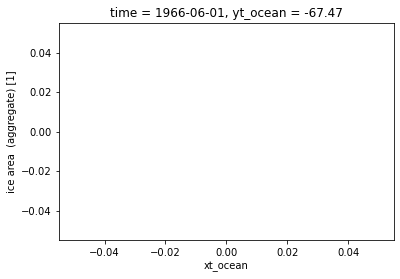

In [5]:
#test after doing the mean depth
#u_speed[0,0,...].plot()
ice_all[100,0,...].plot()

## Remove Climatology

In [6]:
# calculate monthly climatology
climatology = ice_all.groupby('time.month').mean('time')

# remove seasonal signal
ice_all_seasonal_removed = (ice_all - climatology)

In [7]:
#load the variable
ice_all_seasonal_removed = ice_all_seasonal_removed.load()


In [8]:
# select a single month and drop the 'month' dimension
ice_all_seasonal_removed = ice_all_seasonal_removed.isel(month=0).drop('month')

In [9]:
# Note we need to first detrend the data:
ice_all_r = ice_all_seasonal_removed.rolling(time=12, center=True).mean()
ice_all_justroll = ice_all.rolling(time=12, center=True).mean()

### loading indexes previously calculated by "Selecting_peak_low_years" code stored in /Figures/New_codes_CFD

In [10]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [11]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id

### creating the averages for peaks and lows

In [12]:
#full mean, for those without climatology applied
ice_r_avg = ice_all_r.mean('time')
ice_r_avg = ice_r_avg.load()

#mean of all high peaks together
ice_high_avg=ice_all_r[top_id.values].mean('time')
ice_high_avg = ice_high_avg.load()


#mean of all low peaks together
ice_low_avg = ice_all_r[bt_id.values].mean('time')
ice_low_avg = ice_low_avg.load()

In [13]:
#full mean, for those without climatology applied
ice_r_avg2 = ice_all_justroll.mean('time')
ice_r_avg2 = ice_r_avg2.load()

#mean of all high peaks together
ice_high_avg2 = ice_all_justroll[top_id.values].mean('time')
ice_high_avg2 = ice_high_avg2.load()


#mean of all low peaks together
ice_low_avg2 = ice_all_justroll[bt_id.values].mean('time')
ice_low_avg2 = ice_low_avg2.load()

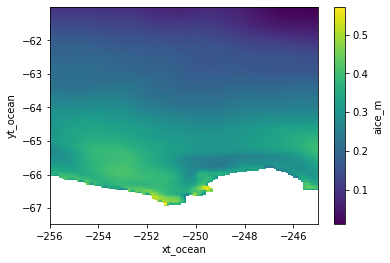

In [14]:
ice_r_avg.plot()

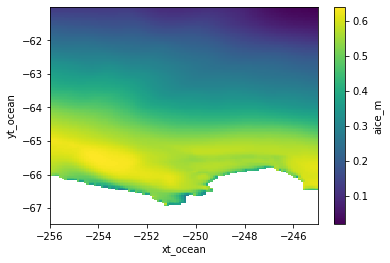

In [15]:
ice_r_avg2.plot()

## PLOT COMPOSITES FOR SEA ICE ANOMALIES - CLIMATOLOGY REMOVED

In [16]:
# cut the data BOX 1
lon_slice  = slice(-255, -240)
lat_slice  = slice(-67, -63)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)



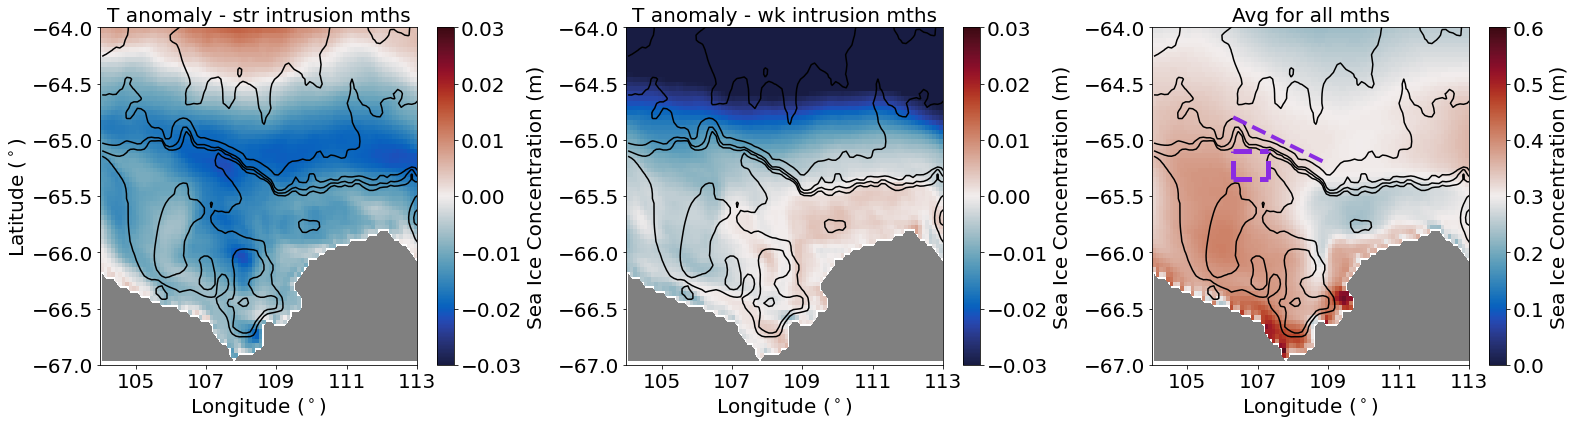

In [18]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = ice_high_avg-ice_r_avg;
t_low = ice_low_avg-ice_r_avg;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.03,vmax=.03)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('T anomaly - str intrusion mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Sea Ice Concentration (m)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.03,vmax=.03)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('T anomaly - wk intrusion mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Sea Ice Concentration (m)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(ice_r_avg.xt_ocean,ice_r_avg.yt_ocean,
                        ice_r_avg, cmap = cmocean.balance, 
                        vmin=0,vmax=0.6)
plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='blueviolet',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='blueviolet',linestyle='--',linewidth=5)
#
plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Sea Ice Concentration (m)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/FigSI_sea-ice_removed_climatology.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

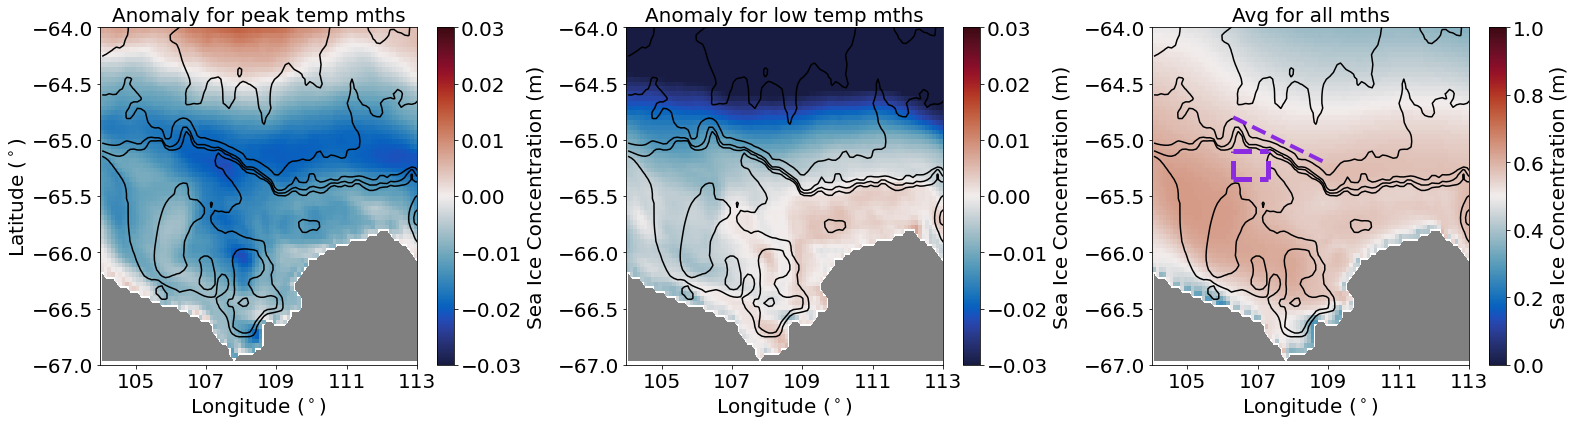

In [18]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = ice_high_avg2-ice_r_avg2;
t_low = ice_low_avg2-ice_r_avg2;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.03,vmax=.03)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for peak temp mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Sea Ice Concentration (m)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.03,vmax=.03)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for low temp mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Sea Ice Concentration (m)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(ice_r_avg2.xt_ocean,ice_r_avg2.yt_ocean,
                        ice_r_avg2, cmap = cmocean.balance, 
                        vmin=0,vmax=1)
plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='blueviolet',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='blueviolet',linestyle='--',linewidth=5)
#
plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Sea Ice Concentration (m)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/FigSI_sea-ice_rolling_mean_only.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

### LOAD SPECIAL CONTOURS

In [91]:
# cut the data BOX 1
lon_slice  = slice(-255, -240)
lat_slice  = slice(-67, -63)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)


In [102]:
# cut the data BOX 1
lat_slice  = slice(-65.3, -63) #eke
lon_slice  = slice(-253.5, -251.1)

# topography data:
ht2 = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht2 = ht2.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask2 = np.squeeze(ht2.values)*0
land_mask2[np.isnan(land_mask2)] = 1
land_mask2 = np.where(land_mask2==1,land_mask2,np.nan)


In [100]:
# cut the data BOX 1
lon_slice  = slice(-251, -246) # sea ice
lat_slice  = slice(-65.6, -63)

# topography data:
ht3 = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht3 = ht3.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask3 = np.squeeze(ht3.values)*0
land_mask3[np.isnan(land_mask3)] = 1
land_mask3 = np.where(land_mask3==1,land_mask3,np.nan)



In [106]:
# cut the data BOX 1
lon_slice  = slice(-251, -246) 
lat_slice  = slice(-65.6, -63)

# topography data:
ht4 = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht4 = ht3.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask4 = np.squeeze(ht4.values)*0
land_mask4[np.isnan(land_mask4)] = 1
land_mask4 = np.where(land_mask4==1,land_mask4,np.nan)


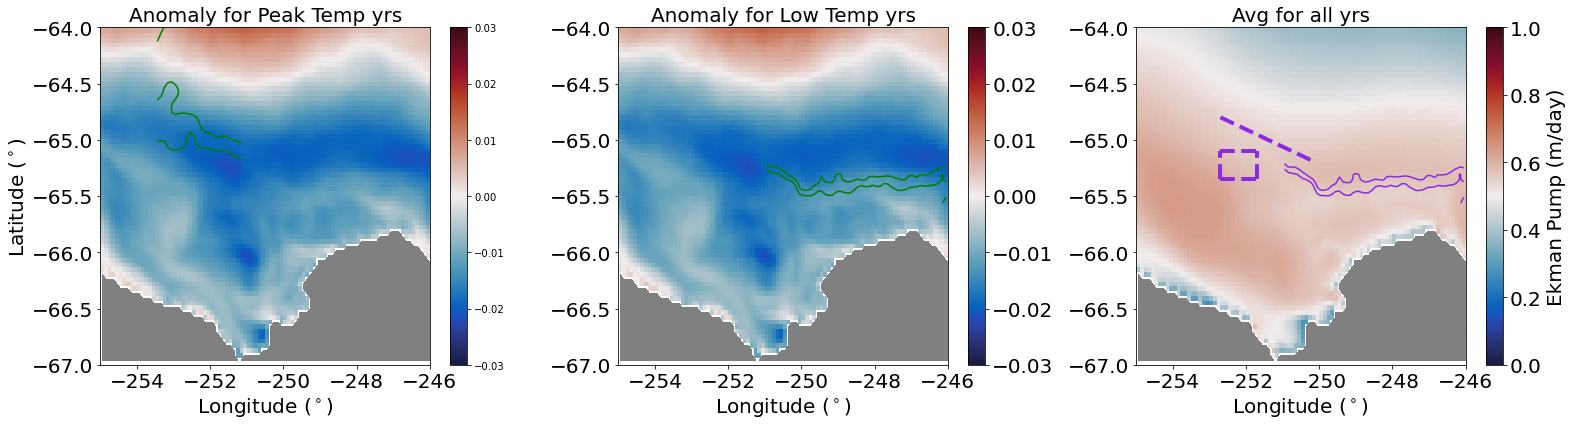

In [108]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = ice_high_avg2-ice_r_avg2;
t_low = ice_low_avg2-ice_r_avg2;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.03,vmax=.03)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
plt.title('Anomaly for Peak Temp yrs',fontsize=fontsize)
        #plot contours
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contour(ht2.xt_ocean,ht2.yt_ocean,ht2,levels=[700,2500],colors='green',linewidth=1)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)

plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.03,vmax=.03)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='magenta',linestyle='--',linewidth=4)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for Low Temp yrs',fontsize=fontsize)
#plt.title('Anomaly for falling Temp yrs',fontsize=fontsize)
        #plot contours
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contour(ht3.xt_ocean,ht3.yt_ocean,ht3,levels=[500,1000],colors='green',linewidth=2.5)
#plt.plot([-250,-247],[-65,-65],'--')
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=20)

#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(ice_r_avg2.xt_ocean,ice_r_avg2.yt_ocean,
                        ice_r_avg2, cmap = cmocean.balance, 
                        vmin=0,vmax=1)
plt.title('Avg for all yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht4.xt_ocean,ht4.yt_ocean,ht4,levels=[500,1000],colors='blueviolet',linewidth=.5)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='blueviolet',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='blueviolet',linestyle='--',linewidth=4)
#
plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ekman Pump (m/day)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)


fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/figSI_sea_ice_special_contour.eps'
plt.savefig(filestr,dpi=600,bbox_inches='tight')